# Natural Language Inference Project

## Intro:

I wanted to see how different newspapers reviews the same event. 

Is there any difference in the titles of the articles? 

To check this I worked on this project.

This task is part of language inference, that called recognizing textual entailment (RTE).



So my project goal: determining how pairs of English sentences are related (entailment connection / contradict / neutral)

**Example:**

*Sentence 1*: "The kids are sad"

*Sentence 2*: "Children smiling and waiving at the camera"

*Conclusion*: Those sentence are contradict ('sad' is the opposite of 'smiling')

**How I tried to do that?**

I used pre-trained Bert model (DistilBert) to get sentences' embeddings;
then I trained Machine Learning models to do the classification task (Logistic Regression, Support Vector Classification and Ensembles)

*Let's get started:*

##Loading the Data:

For minimal viable product (MVP) I'll implement my project on prepared dataset of Stanford University, named SNLI: 

Dataset source: https://nlp.stanford.edu/projects/snli/

Download the dataset: https://nlp.stanford.edu/projects/snli/snli_1.0.zip

I mounted the dataset into my google drive and loaded it from there:


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Navigating into the folder I saved in the dataset:

In [2]:
%cd drive/MyDrive/Colab Notebooks/NLP_Project/

/content/drive/MyDrive/Colab Notebooks/NLP_Project


##Importing packages:

Installing transformers package:

In [3]:
!pip install transformers

     |████████████████████████████████| 1.8MB 6.9MB/s 
     |████████████████████████████████| 2.9MB 29.5MB/s 
     |████████████████████████████████| 890kB 21.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8ca43f9f18f8e2a698ba4dace3ebce3d6f71a4073610157567c18dd79374b992
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as svc
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tqdm.notebook import tqdm
import torch
import transformers as trnsf
import warnings
warnings.filterwarnings('ignore')

## Exploring the dataset:

I took the 'snli_1.0_train.csv' dataset for training and testing before using newspapers titles

Loading the sentences and their label:

In [5]:
cols = ['gold_label', 'sentence1', 'sentence2']
df = pd.read_csv('snli_1.0_train.csv', engine='python', usecols=cols)

Taking a look at the dataset information:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550152 entries, 0 to 550151
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   gold_label  550152 non-null  object
 1   sentence1   550152 non-null  object
 2   sentence2   550146 non-null  object
dtypes: object(3)
memory usage: 12.6+ MB


Some sentences in the "sentence2" column are missing, so we need to drop those rows.

In [7]:
df = df[~df['sentence2'].isnull()]

Let's check again the dataset information:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550146 entries, 0 to 550151
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   gold_label  550146 non-null  object
 1   sentence1   550146 non-null  object
 2   sentence2   550146 non-null  object
dtypes: object(3)
memory usage: 16.8+ MB


Problem fixed! the count in all the columns is the same.

Now let's check if there are weird labels:

In [9]:
df.gold_label.value_counts()

entailment       183414
contradiction    183185
neutral          182762
-                   785
Name: gold_label, dtype: int64

There are 785 rows with undifined category, for convenience, let's drop them too.

In [10]:
df = df[(df.gold_label != "-")]

Checking:

In [11]:
df.gold_label.value_counts()

entailment       183414
contradiction    183185
neutral          182762
Name: gold_label, dtype: int64

 Problem fixed!

Now let's plot the distribution of the categories:

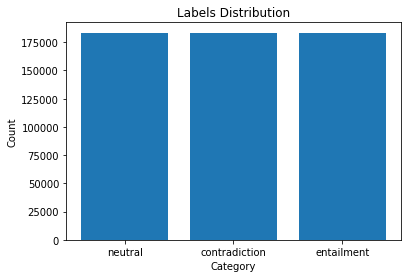

In [12]:
plt.bar(df.gold_label.unique(),df.gold_label.value_counts())
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Labels Distribution')
plt.show()

The categories distribute equally.

Printing the shape of the dataset:

In [13]:
print(df.shape)

(549361, 3)


Let's take a look how our dataset looks like:

In [14]:
df.head()

,gold_label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


We can see the bunch of sentences with similar varient. We want the model expose to different sentences and won't learn things by this order so, let's shuffle the dataset and increase the variance:

In [15]:
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

Taking another look at the dataset:

In [16]:
df.head()

,gold_label,sentence1,sentence2
0,neutral,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water.
1,entailment,A woman is smiling while the man next to her i...,Two people are next to each other.
2,neutral,"Across the river, you can see a large building.",The large building is full of apartments and t...
3,contradiction,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean.
4,contradiction,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...


Great! 

---

## Pre-trained BERT model

### Why I chose BERT model? and why I chose to use DistilBERT version?


* BERT is bidirectional model - it can read a text (or a sequence of words) all at once, with no specific direction (it's not limited only to left-to-right or right-to-left).
Because of that, BERT can understand the meaning of each word based on context both to the right and to the left of the word.

* DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base.
This allows me to train greater amount of sentences in google colab environment.

### Loading BERT model:

In [17]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (trnsf.DistilBertModel, trnsf.DistilBertTokenizer, 'distilbert-base-uncased')

# For Bert:
#model_class, tokenizer_class, pretrained_weights = (trnsf.BertModel, trnsf.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

### Creating functions for future use:

*Tokenizing and Padding*

Tokenizing is the process of transfering the sentences into a vectors.
Computers and specifically BERT model doesn't understand words, so we need to "translate" them into numbers that can be processed. 
In the tokenizing process every word (or part of it) get id number and it enters into a vector of the sentence. 

Padding is adding zeros at the end of the sentences (padding id is zero).
We use it to make sure all the sentences have the same length. 

In [18]:
def get_tokenized_sentences(sentences):
    """
    This function tokenizing and padding the sentences.
    sentences parameter is a pandas series of sentences.
    max_length parameter is the limit for how much padding to add to the sentence vector.
    """
    tokenized_sen = sentences.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    return tokenized_sen


def find_max_len(tokenized_sen):
    """
    This function finds the max length of the tokenized sentences
    tokenized_sen parameter is a pandas series of tokenized sentences.
    """
    max_len = 0
    for i in tokenized_sen.values:
        if len(i) > max_len:
            max_len = len(i)
    return max_len


def padding(tokenized_sen, max_len):
    """
    tokenized_sen parameter is a pandas series of tokenized sentences.
    max_len parameter defines the length of the tokenized sentences after padding.
    """
    padded_sentences = np.array([i + [0]*(max_len-len(i)) for i in tokenized_sen.values])
    return padded_sentences

Example:

I took a sentence and transfered it into pandas series (so the function can use it) and printed the tokenized form of it and the padded form with max_len of 10.

In [19]:
my_sentence = "Hello world"
my_sentence = pd.Series(my_sentence)

my_sentence_tokenized = get_tokenized_sentences(my_sentence)
print("tokenized:", my_sentence_tokenized)

my_sentence_padded = padding(my_sentence_tokenized, 10) 
print("padded:", my_sentence_padded)

tokenized: 0    [101, 7592, 2088, 102]
dtype: object
padded: [[ 101 7592 2088  102    0    0    0    0    0    0]]


To understand what we got let's use convert_ids_to_tokens method: 

In [20]:
print('101 id is: ', tokenizer.convert_ids_to_tokens(101))
print('7592 id is: ',tokenizer.convert_ids_to_tokens(7592))
print('2088 id is: ',tokenizer.convert_ids_to_tokens(2088))
print('102 id is: ',tokenizer.convert_ids_to_tokens(102))
print('0 id is: ',tokenizer.convert_ids_to_tokens(0))

101 id is:  [CLS]
7592 id is:  hello
2088 id is:  world
102 id is:  [SEP]
0 id is:  [PAD]


[CLS] and [SEP] are tokens to indicate the model where the sentence begins and ends.
[PAD] is for padding.

*Masking*



Masking or attention mask tells BERT to ignore (mask) the padding we have added and focus only at thhe sentence itself. 

In [21]:
def masking(padded_sentences):
    """
    This function creates attention_mask.
    padded_sentence parameter is a pandas series of padded sentences.
    """
    attention_mask = np.where(padded_sentences != 0, 1, 0)
    return attention_mask

Let's print the attention mask for out example sentence:

In [22]:
my_attention_mask = masking(my_sentence_padded)
print(my_attention_mask)

[[1 1 1 1 0 0 0 0 0 0]]


We can see the attention vector tells BERT to focus on the first four words and ignore the other (the padding we just added).

*BERT model*

The next function takes the padded sentences and attention mask, put them into the BERT model and gives us embeddings vectors; vectors that represent the meaning of the sentences, those will be out features.

In [23]:
def get_embeddings(padded_sentences, attention_mask):
    """
    This function takes the padded sentences and the attention mask and creates embeddings.
    """
    input_ids = torch.tensor(padded_sentences)  
    attention_mask = torch.tensor(attention_mask)
    with torch.no_grad():
        last_hidden_state = model(input_ids, attention_mask = attention_mask)

    embeddings = last_hidden_state[0][:,0,:].numpy()

    return embeddings

And finally let's print the embedding vector for our example:

In [24]:
my_sentence_embedding = get_embeddings(my_sentence_padded, my_attention_mask)

The shape of the vector: (1, 768) 



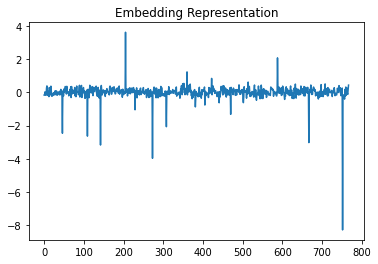

In [25]:
plt.plot(my_sentence_embedding.reshape(-1,1))
plt.title('Embedding Representation');

print("The shape of the vector:", my_sentence_embedding.shape, "\n")

This vector represents the meaning of the sentence "Hello World".

---

Now let's create function to run all the function I created together:

In [26]:
def bert_model(sentence1, sentence2, max_len=100):
    """
    This function receives two sentences (or pandas series of sentences) and creates embedding vectors for them.
    max_len parameter is the max length of the padding vector.
    """
    sentence1 = pd.Series(sentence1)
    sentence2 = pd.Series(sentence2)

    tokenized_sen1 = get_tokenized_sentences(sentence1)
    tokenized_sen2 = get_tokenized_sentences(sentence2)

    max_len_s1 = find_max_len(tokenized_sen1)
    max_len_s2 = find_max_len(tokenized_sen2)
    max_len = max(max_len_s1, max_len_s2, max_len)

    padded_s1 = padding(tokenized_sen1, max_len)
    padded_s2 = padding(tokenized_sen2, max_len)

    attention_mask_s1 = masking(padded_s1)
    attention_mask_s2 = masking(padded_s2)

    embeddings_s1 = get_embeddings(padded_s1, attention_mask_s1)
    embeddings_s2 = get_embeddings(padded_s2, attention_mask_s2)

    return embeddings_s1, embeddings_s2

And a function for plotting:

In [27]:
def plot_embeddings(embeddings_s1, embeddings_s2):
    """
    This function receives two embedding functions and plot them together
    """
    plt.figure(figsize=(10,5))
    plt.plot(embeddings_s1.reshape(-1,1), label='sentence1')
    plt.plot(embeddings_s2.reshape(-1,1), label='sentence2')
    plt.legend(loc='lower left');

### Let's see if there is any difference in the plots of the categories:

In [28]:
entailment = df.loc[df['gold_label'] == 'entailment'].reset_index(drop=True)
contradiction = df.loc[df['gold_label'] == 'contradiction'].reset_index(drop=True)
neutral = df.loc[df['gold_label'] == 'neutral'].reset_index(drop=True)

*Entailment:*

In [29]:
print("label:", entailment['gold_label'][0])
print("sentence1", entailment['sentence1'][0])
print("sentence2", entailment['sentence2'][0])

label: entailment
sentence1 A woman is smiling while the man next to her is focused on a blue object with a pattern on it.
sentence2 Two people are next to each other.


Running all the functions to get the embeddings and plotting:

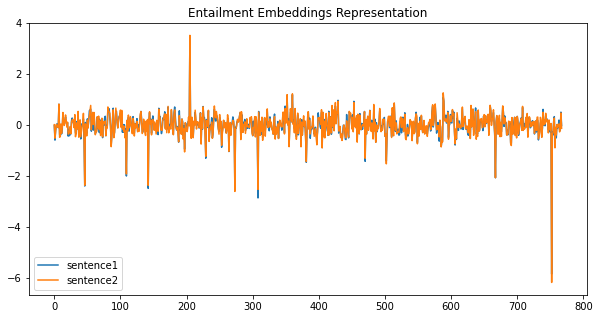

In [30]:
embeddings_s1_ent, embeddings_s2_ent = bert_model(df['sentence1'][0], df['sentence2'][0])
plot_embeddings(embeddings_s1_ent, embeddings_s2_ent)
plt.title('Entailment Embeddings Representation');

*Contradiction*

In [31]:
print("label:", contradiction['gold_label'][0])
print("sentence1", contradiction['sentence1'][0])
print("sentence2", contradiction['sentence2'][0])

label: contradiction
sentence1 a man in white shorts and a black shirt is paragliding on the ocean
sentence2 A man is riding a jetski on the ocean.


Running all the functions to get the embeddings and plotting:

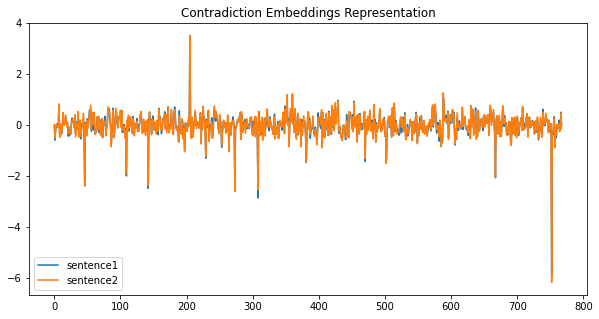

In [32]:
embeddings_s1_cont, embeddings_s2_cont = bert_model(df['sentence1'][0], df['sentence2'][0])
plot_embeddings(embeddings_s1_cont, embeddings_s2_cont)
plt.title('Contradiction Embeddings Representation');

*Neutral*

In [33]:
print("label:", neutral['gold_label'][0])
print("sentence1", neutral['sentence1'][0])
print("sentence2", neutral['sentence2'][0])

label: neutral
sentence1 A young girl in a pink shirt sitting on a dock viewing a body of water.
sentence2 A young girl watching the sunset over the water.


Running all the functions to get the embeddings and plotting:

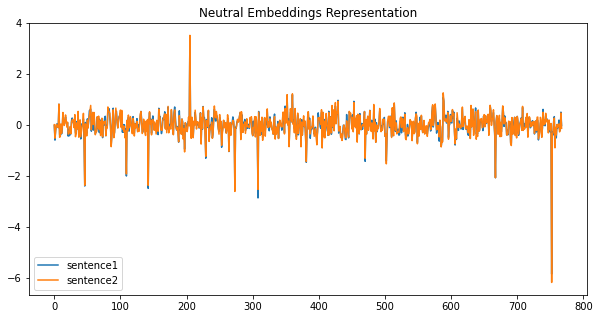

In [34]:
embeddings_s1_neu, embeddings_s2_neu = bert_model(df['sentence1'][0], df['sentence2'][0])
plot_embeddings(embeddings_s1_neu, embeddings_s2_neu)
plt.title('Neutral Embeddings Representation');

We can see there is some difference between the plots but we can't say by looking at them that we can distinguish between the categories only by the plot.

Let's hope the models we'll train will do the work :)

---

## Modeling

Let's return to our business:


Because of RAM and time limitations, I'll create batches and train my model on 15,000 rows and test it on 5,000 rows.

Let's split the data set into train and test subsets. I use shuffle to increase the variance and stratify to make sure the categories distribute evenly in the train and test subsets. X represents sentence1 and sentence2 columns and y represents our categories / labels.

In [35]:
train_size = 1500
test_size = 500

# train_size = 15000
# test_size = 5000

X_train, X_test, y_train, y_test = train_test_split(df[['sentence1', 'sentence2']],
                                                    df['gold_label'], test_size=test_size,
                                                    train_size=train_size, random_state=1,
                                                    shuffle=True, stratify=df['gold_label'])

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

I'm reseting the indices so we can loop over those datasets.

Checking the shapes and value counts of the subsets:

In [36]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1500, 2)
y_train shape: (1500,)
X_test shape: (500, 2)
y_test shape: (500,)


In [37]:
print("Train:\n", y_train.value_counts(), "\n")
print("Test:\n", y_test.value_counts())

Train:
 entailment       501
contradiction    500
neutral          499
Name: gold_label, dtype: int64 

Test:
 contradiction    167
entailment       167
neutral          166
Name: gold_label, dtype: int64


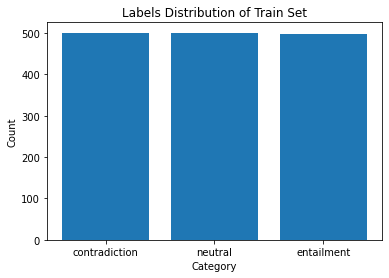

In [38]:
plt.bar(y_train.unique(),y_train.value_counts())
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Labels Distribution of Train Set')
plt.show()

Good, The shapes as defined and the distribution of the categories is quite similar.

Let's create embeddings for "sentence1" and "sentence2" columns.

It's gonna take a while...

In [93]:
total_embeddings_s1_train = []
total_embeddings_s2_train = []

for i in tqdm(range(int(train_size / 500))): 
    batch = X_train[i*500:i*500+500]
    embeddings_s1, embeddings_s2 = bert_model(batch['sentence1'], batch['sentence2'])

    total_embeddings_s1_train.extend(embeddings_s1)
    total_embeddings_s2_train.extend(embeddings_s2)

In [95]:
total_embeddings_s1_test = []
total_embeddings_s2_test = []

for i in tqdm(range(int(test_size / 500))): 
    batch = X_test[i*500:i*500+500]
    embeddings_s1, embeddings_s2 = bert_model(batch['sentence1'], batch['sentence2'])

    total_embeddings_s1_test.extend(embeddings_s1)
    total_embeddings_s2_test.extend(embeddings_s2)

Converting the list into numpy array:

In [96]:
total_embeddings_s1_train = np.asarray(total_embeddings_s1_train)
total_embeddings_s2_train = np.asarray(total_embeddings_s2_train)

total_embeddings_s1_test = np.asarray(total_embeddings_s1_test)
total_embeddings_s2_test = np.asarray(total_embeddings_s2_test)


Checking the length of the embedding vectors is equal:

In [97]:
print(len(total_embeddings_s1_train) == len(total_embeddings_s2_train))
print(len(total_embeddings_s1_test) == len(total_embeddings_s2_test))

True
True


Okay, now that we have the embeddings, let's try few ways using the embeddings for classification modeling: 

1. calculating cosine similarity - technique to check how similar the vectors are by their angle.
2. subtracting the embeddings vectors.
3. concatenating the embeddings vectors.

1. *cosine similarity*

Calculating the cosine similarity and plotting it

In [98]:
cosine_similarity_embeddings = [1 - spatial.distance.cosine(total_embeddings_s1_train[i], total_embeddings_s2_train[i]) for i in range(len(total_embeddings_s1_train))]
cosine_similarity_embeddings = np.asarray(cosine_similarity_embeddings)

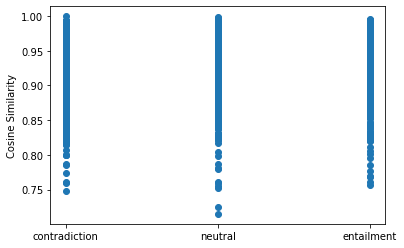

In [72]:
plt.scatter(y_train, cosine_similarity_embeddings)
plt.ylabel('Cosine Similarity');

We can see the cosine similarity value of the labels is in the same range approximately between 0.75 - 1, that means we can't distinguish by it between the labels, and therefore it's not a good technique for that case. 

2. *subtracting the embeddings vectors.*

In [99]:
subtract_embeddings_train = total_embeddings_s1_train - total_embeddings_s2_train 
subtract_embeddings_test = total_embeddings_s1_test - total_embeddings_s2_test

This one we can't plot, because it's not 2D. 

In [100]:
subtract_embeddings_train.shape

(1500, 768)

3. *concatenating the embeddings vectors.*


In [101]:
concat_embeddings_train = np.concatenate((total_embeddings_s1_train, total_embeddings_s2_train), axis=1)
concat_embeddings_test = np.concatenate((total_embeddings_s1_test, total_embeddings_s2_test), axis=1)

We can't plot this one too, also because it's not 2D.

In [102]:
concat_embeddings_train.shape

(1500, 1536)

Now we'll create functions for implementing Machine Learning models with 2+3 techniques to see if we succeed to classify the embeddings into our 3 categories: entailment, contradiction and neutral.

In [126]:
def classifier(clf, embeddings_train, labels_train, embeddings_test, labels_test):
    """
    This function apply logistic regression model.
    The function receives classifier object, the embeddings of the train & test sets and their labels.
    """
    clf.fit(embeddings_train, labels_train)
    score = clf.score(embeddings_test, labels_test)
    predict = clf.predict(embeddings_test)
    return score, predict


def get_confusion_matrix(clf, embeddings_test, true_labels_test, predicted_labels_test):
    """
    This function calculates the confusion matrix and plot it.
    It receives the classifier object, true labels and the predicted ones.
    """
    c_m = confusion_matrix(true_labels_test, predicted_labels_test, labels=true_labels_test.unique())
    plot_confusion_matrix(clf, embeddings_test, true_labels_test, normalize='true')
    plt.title('Confusion Matrix') 
    plt.show()
    return c_m


def cross_validation(clf, embeddings_train, labels_train, embeddings_test, labels_test, cv=7):
    """
    This function calculates the cross validation score (accuracy). 
    It receives the classifier object, train & test embeddings, train & test lables
    and 'cv' - number of groups for cross validation.
    """
    embeddings = np.concatenate((embeddings_train, embeddings_test), axis=0)
    labels =  np.concatenate((labels_train, labels_test), axis=0)
    return np.mean(cross_val_score(clf, embeddings, labels, cv=cv))


Explantion about what we see in the functions above:

- 'clf' is the classifier object
- score is the accuracy of the model
- predict gives us the categories the model predicted on the test set
- confusion matrix tells us how well the model classified each category
- cross validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

To use the Machine Learning models, first we need to initiate classifier object, then we train the model using our train subset and finally evaluate the results using the test subset.

**Logistic Regression**

Initiating Logistic Regression object:

In [104]:
lr_clf = LogisticRegression()

**SVC (Support Vector Classification)**

Initiating SVC object:

In [127]:
svc_clf = svc(kernel='linear', C=1)


**Ensembles**

Initiating Ensembles object:

In [106]:
ecf = VotingClassifier(estimators=[('lr', lr_clf), ('svc', svc_clf)], voting='hard')

Ensembles uses multiple models to obtain better predictive performance than could be obtained from any of models alone.

The predictions from all of the models combined through a weighted majority vote (or sum) to produce the final prediction.

### Applying the models:

**Subtracting the embeddings vectors:**

*Logistic Regression*

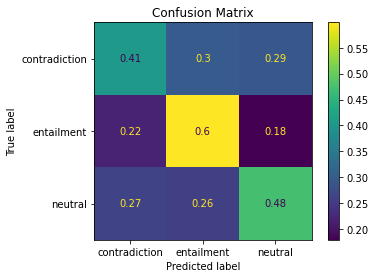

Accuracy: 0.494
Cross Validation Accuracy: 0.5070000175263333


In [129]:
score_subt_lr, predict_subt_lr = classifier(lr_clf, subtract_embeddings_train, y_train, subtract_embeddings_test, y_test)
c_m_subt_lr = get_confusion_matrix(lr_clf, subtract_embeddings_test, y_test, predict_subt_lr)
cross_val_subt_lr = cross_validation(lr_clf, subtract_embeddings_train, y_train, subtract_embeddings_test, y_test, cv=7)

print('Accuracy:', score_subt_lr)
print('Cross Validation Accuracy:', cross_val_subt_lr)

Explanation about what we see in the confusion matrix:

In the diagram above, we see our three categories and the percentage of each case. 
If we look on neutral & neurtal we will see 0.48, that mean the model succeed in 48% of the times to classify neutral connection as neutral.
The higher probability, the performances of the model are better.

We can see that this model succeed to identify entailment cases better than neutral and contradiction.

If we compare the percentages we got here with the confusion matrix of the other models, we can see which model is better than the others.

*SVC*

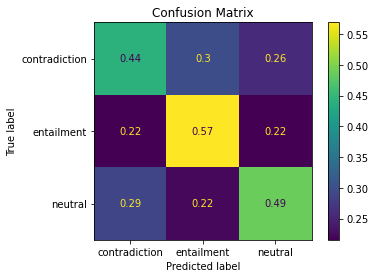

Accuracy: 0.5
Cross Validation Accuracy: 0.4925004819741662


In [132]:
score_subt_svc, predict_subt_svc = classifier(svc_clf, subtract_embeddings_train, y_train, subtract_embeddings_test, y_test)
c_m_subt_svc = get_confusion_matrix(svc_clf, subtract_embeddings_test, y_test, predict_subt_svc)
cross_val_subt_svc = cross_validation(svc_clf, subtract_embeddings_train, y_train, subtract_embeddings_test, y_test, cv=7)

print('Accuracy:', score_subt_svc)
print('Cross Validation Accuracy:', cross_val_subt_svc)


*Ensembles*

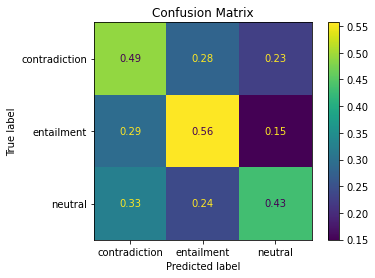

Accuracy: 0.494
Cross Validation Accuracy: 0.49399898347266774


In [133]:
score_subt_ecf, predict_subt_ecf = classifier(ecf, subtract_embeddings_train, y_train, subtract_embeddings_test, y_test)
c_m_subt_ecf = get_confusion_matrix(ecf, subtract_embeddings_test, y_test, predict_subt_ecf)
cross_val_subt_ecf = cross_validation(ecf, subtract_embeddings_train, y_train, subtract_embeddings_test, y_test, cv=7)

print('Accuracy:', score_subt_ecf)
print('Cross Validation Accuracy:', cross_val_subt_ecf)

**Concatenating the embeddings vectors:**

*Logistic Regression*

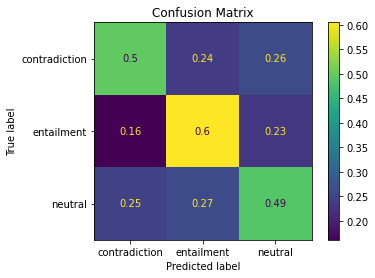

Accuracy: 0.53
Cross Validation Accuracy: 0.5210070631123263


In [134]:
score_conc_lr, predict_conc_lr = classifier(lr_clf, concat_embeddings_train, y_train, concat_embeddings_test, y_test)
c_m_conc_lr = get_confusion_matrix(lr_clf, concat_embeddings_test, y_test, predict_conc_lr)
cross_val_conc_lr = cross_validation(lr_clf, concat_embeddings_train, y_train, concat_embeddings_test, y_test, cv=7)

print('Accuracy:', score_conc_lr)
print('Cross Validation Accuracy:', cross_val_conc_lr)

*SVC*

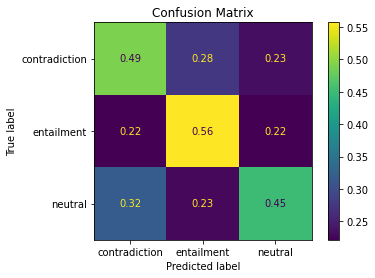

Accuracy: 0.5
Cross Validation Accuracy: 0.49899574110100414


In [135]:
score_conc_svc, predict_conc_svc = classifier(svc_clf, concat_embeddings_train, y_train, concat_embeddings_test, y_test)
c_m_conc_svc = get_confusion_matrix(svc_clf, concat_embeddings_test, y_test, predict_conc_svc)
cross_val_conc_svc = cross_validation(svc_clf, concat_embeddings_train, y_train, concat_embeddings_test, y_test, cv=7)

print('Accuracy:', score_conc_svc)
print('Cross Validation Accuracy:', cross_val_conc_svc)

*Ensembles*

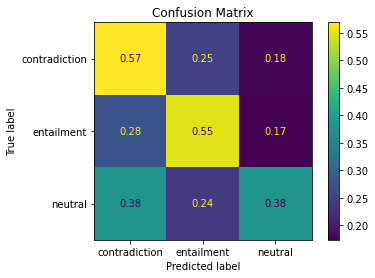

Accuracy: 0.5
Cross Validation Accuracy: 0.5010042588989957


In [136]:
score_conc_ecf, predict_conc_ecf = classifier(ecf, concat_embeddings_train, y_train, concat_embeddings_test, y_test)
c_m_conc_ecf = get_confusion_matrix(ecf, concat_embeddings_test, y_test, predict_conc_ecf)
cross_val_conc_ecf = cross_validation(ecf, concat_embeddings_train, y_train, concat_embeddings_test, y_test, cv=7)

print('Accuracy:', score_conc_ecf)
print('Cross Validation Accuracy:', cross_val_conc_ecf)

## Comparing the models:

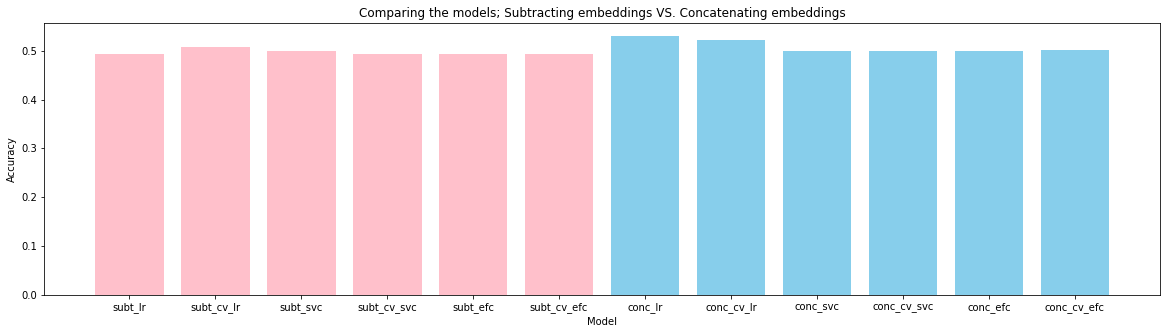

In [148]:
subt = {'subt_lr':score_subt_lr, 'subt_cv_lr':cross_val_subt_lr,
        'subt_svc':score_subt_svc, 'subt_cv_svc':cross_val_subt_svc,
        'subt_efc':score_subt_ecf, 'subt_cv_efc':cross_val_subt_ecf}

conc =  {'conc_lr':score_conc_lr, 'conc_cv_lr':cross_val_conc_lr,
        'conc_svc':score_conc_svc, 'conc_cv_svc':cross_val_conc_svc,
        'conc_efc':score_conc_ecf, 'conc_cv_efc':cross_val_conc_ecf}

plt.figure(figsize=(20,5))
plt.bar(*zip(*subt.items()), color='pink')
plt.bar(*zip(*conc.items()), color='skyblue')
plt.title('Comparing the models; Subtracting embeddings VS. Concatenating embeddings')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

As we can see the logistic regression model with the concatenated embeddings gives the best result.

## Testing the models on newspapers:

***To complete:*** taking articles titles, get their embeddings and trying to see how the best model performs on it. (add screen-shots of the titles)